In [9]:
%load_ext autoreload
%autoreload 2

import torch
# from PolySym import Regressor, Operators
from polysym.torch_operators_2 import Operators
from polysym.regressor import Configurator
from polysym.model import PolySymModel
from polysym.evaluation import r2
from polysym.utils import compile_tree
import random

n_obs = 100

X3d = torch.zeros((n_obs, 2, 50))
sequences = []
X2d = torch.zeros((n_obs, 1))
y1d = torch.zeros(n_obs)
# y2d = torch.zeros(n_obs, 150)
y2d = torch.full((n_obs, 50), torch.nan)

for obs in range(n_obs):

    length = random.randint(25, 50)

    start, end = torch.rand(2) * 100

    x1 = torch.linspace(start, end, length)
    x2 = torch.cos(torch.linspace(start, end, length))

    x12 = torch.vstack([x1, x2]).T
    sequences.append(x12)

    b = torch.randint(low=-10, high=10, size=(1, 1))

    y = (b + x1 + (x1 * x2))
    # expr=binary_add(binary_add(x0, n0), binary_mul(v1, v0))

    expr = 'binary_add(binary_add(x0, v0), binary_mul(v0, v1))'

    X3d[obs, 0, :length] = x1
    X3d[obs, 1, :length] = x2
    X2d[obs] = b
    y1d[obs] = torch.nanmean(y).item()
    y2d[obs, :length] = y

sequences = torch.nn.utils.rnn.pad_sequence(sequences, padding_value=torch.nan)
X3d = sequences
X3d = X3d.permute(1, 2, 0)
print(X3d.shape)

operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])

model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y2d,
                        labels_2d=['b'],
                        labels_3d=['vec0', 'vec1'],
                        operators=None,
                        min_complexity=1,
                        max_complexity=4,
                        scale=False,
                        add_constants=False,
                        pop_size=200,
                        max_iter=200,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=43,
                        verbose=1,
                        optimize_ephemerals=False,
                        workers=-1)

#print(model.eval_expr(expr))

# TODO: fix scaling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([100, 2, 50])


In [10]:
import os, torch, multiprocessing as mp

"""# ---- put this at the top of your main script ----
for var in ("OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS"):
    os.environ[var] = "1"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)"""

if mp.get_start_method(allow_none=True) != "fork":
    mp.set_start_method("fork", force=True)   # Linux, CPU‑only
# -----------------------------------------------

model.fit()

2025-05-04 12:00:32,025 - INFO - Running iteration 0/200; best fit=-inf
2025-05-04 12:00:41,207 - INFO - Running iteration 10/200; best fit=0.79
2025-05-04 12:00:47,588 - INFO - Running iteration 20/200; best fit=0.79
2025-05-04 12:00:54,902 - INFO - Running iteration 30/200; best fit=0.79
2025-05-04 12:01:03,077 - INFO - Running iteration 40/200; best fit=0.79
2025-05-04 12:01:10,974 - INFO - Running iteration 50/200; best fit=0.79
2025-05-04 12:01:20,242 - INFO - Running iteration 60/200; best fit=1.00
2025-05-04 12:01:28,496 - INFO - Running iteration 70/200; best fit=1.00
2025-05-04 12:01:37,666 - INFO - Running iteration 80/200; best fit=1.00
2025-05-04 12:01:41,025 - INFO - Running iteration 90/200; best fit=1.00
2025-05-04 12:01:44,481 - INFO - No improvements in loss for 50 generations; modifying genetic hyperparameters:
2025-05-04 12:01:44,488 - INFO - Increased mating probability by 5%: cxpb=0.55
2025-05-04 12:01:44,489 - INFO - Increased mutation probability by 5%: mutpb=0.2

In [11]:
model.summary(pretty_print=False)

Best depth=None

Depth=1 fitness=0.25 expr: add(v0, v1)

Depth=2 fitness=1.00 expr: add(mul(v0, v1), add(x0, v0))

Depth=3 fitness=0.91 expr: sub(add(median(v0), sub(x0, x0)), sub(sqrt(x0), mul(v1, v0)))

Depth=4 fitness=0.79 expr: abs(add(mul(exp(v1), neg(v0)), cos(min(v0))))



In [6]:
#tree = model.get_expr('add(add(x0, v0), mul(v0, v1))')
model.eval_expr('mean(add(add(x0, v0), mul(v0, v1)))')

1.0

In [24]:
#x = model.predict_expr('add(sum(v0), v0)')
x = model.predict_expr('sub(mul(median(v1), max(v1)), center(log10(v0)))')
x = model.predict_expr('cos(abs(add(exp(v0), min(v1))))')

In [25]:
xtrue = X3d[:, 0, :]

print(all(xtrue.isnan().flatten() == x.isnan().flatten()))

False


In [26]:
x

tensor([[-0.3419,  0.9566,  0.8815, -0.0623, -0.0688,  0.8291, -0.1105,  0.5654,
          0.4935, -0.1302, -0.6442,  0.7223, -0.9156,  0.9371, -0.6935,  0.1093,
          0.9763, -0.4267, -0.7546,  0.9314,  0.4674, -0.9883,  0.5901,  0.2603,
          0.4076,  0.0526, -0.9525,  0.9999,  0.8368,  0.9343,  0.5904,  0.5404,
         -0.2127, -0.3202,  0.4832, -0.6088, -0.8140,  0.9746,  0.8513, -0.7504,
          0.9154,  0.6441,  0.7702,     nan],
        [-0.4058, -0.9952, -0.0910, -0.0444, -0.9762, -0.9864,  0.0088, -0.1557,
          0.5687,  0.3126,  0.9455,  0.5041, -0.9367, -0.1286, -0.5777,  0.7856,
         -0.1079,  0.5521,  0.9978, -0.5191,  0.7718,  0.2759, -0.2052, -0.9565,
          0.0692, -0.7690, -0.2978,  0.7838, -0.8798,  0.6079,  0.4929, -0.9660,
          0.9546,  0.1869, -0.7014, -0.3140, -0.9918,  0.2033, -1.0000,  0.2158,
         -0.7846, -0.5388, -0.9549,  0.9907],
        [-0.9196, -0.9454, -0.7191,  0.7165, -0.4568, -0.7601, -0.8469,  0.7668,
         -0.6689,

In [25]:
xtrue.shape

torch.Size([10, 47])

In [8]:
model.best_per_depth

{1: (0.27977438108825686,
  'add(v0, v1)',
   <deap.gp.Terminal at 0x11e5f24c0>]),
 2: (0.9361527231674195,
  'sub(mul(v0, v1), sub(x0, v0))',
   <deap.gp.Terminal at 0x1294982c0>]),
 3: (0.9081979792327881,
  'sub(mul(center(v1), mean(v0)), neg(add(v1, v0)))',
   <deap.gp.Terminal at 0x12a952840>]),
 4: (0.3589653307876587,
  'sub(mul(div(abs(v0), spearmanr(v1, v1)), sqrt(sqrt(v1))), div(pearsonr(sqrt(v1), mul(v1, v1)), sqrt(exp(-0.73))))',
   <deap.gp.randc at 0x11e5be120>])}

In [5]:
(model.hof[0].fitness)

0.9843836096267701

In [8]:
for t in (model.S, model.V):
    for i in model.pset.primitives[t]:
        print(i.name)

neg
abs
sin
cos
tan
sqrt
exp
log
log10
mean
median
sum
std
min
max
add
sub
mul
div
cov
pearsonr
spearmanr
neg
abs
sin
cos
tan
sqrt
exp
log
log10
center
add
add
add
sub
sub
sub
mul
mul
mul
div
div
div


In [22]:
i = -11
print(model.pset.primitives[model.V][i].args)
print(model.pset.primitives[model.V][i].ret)
print(model.pset.primitives[model.V][i].name)
dir(model.pset.primitives[model.V][i])

[<class 'polysym.regressor.Vector'>, <class 'polysym.regressor.Scalar'>]
<class 'polysym.regressor.Vector'>
add


['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 'args',
 'arity',
 'format',
 'name',
 'ret',
 'seq']

In [5]:
model.pset.terminals.items()

dict_items([(<class 'polysym.regressor.Scalar'>, [<deap.gp.Terminal object at 0x10e18af40>, <class 'deap.gp.randc'>]), (<class 'polysym.regressor.Vector'>, [<deap.gp.Terminal object at 0x10d1eacc0>, <deap.gp.Terminal object at 0x10d8d3840>])])

In [72]:
for ret_type, terms in model.pset.terminals.items():
    print(ret_type.__name__, type(ret_type))
    print([i.name for i in terms])


Scalar <class 'type'>
['x0', 'randc']
Vector <class 'type'>
['v0', 'v1']


In [45]:
rd = {f'ARG{i}': s for i, s in enumerate(model.symbols)}
rd

{'ARG0': x0, 'ARG1': v0, 'ARG2': v1}

In [85]:
import sympy as sp

str(sp.symbols('hello'))

'hello'

In [83]:
ind = model.toolbox.population_depth_2(n=1)[0]
type(ind)

deap.creator.Individual

[]

In [20]:
j = 0
for ret_type, terms in model.pset.terminals.items():
    for i, term in enumerate(terms):
        n = term.name
        if n[-1] == '0':
            nn = 'x0'
        else:
            nn = f'v{j}'
            j += 1
        model.pset.terminals[ret_type][i].name = nn

In [230]:
from sympy import Expr
import sympy as sp
from graphviz import Digraph
from polysym.utils import _round_floats

def draw_expr_tree(expr: Expr, filename: str = 'expr_tree', format: str = 'png') -> None:
    """
    Render the tree of a SymPy expression using Graphviz,
    with the full expression printed below.
    """
    dot = Digraph(format=format)
    # set the graph label to the expression and put it at the bottom
    dot.graph_attr['spi'] = '300'
    dot.graph_attr['size'] = '20,20!'
    #dot.attr(label=str(expr), labelloc='b', fontsize='12')

    counter = {'i': 0}

    def node_label(e):
        return e.func.__name__ if e.args else str(e)

    def add(e):
        idx = str(counter['i'])
        counter['i'] += 1
        dot.node(idx, node_label(e))
        for arg in e.args:
            child_idx = add(arg)
            dot.edge(idx, child_idx)
        return idx

    add(expr)
    dot.render(filename, cleanup=True)

expr = model.best_per_depth[3][1]
expr = 'unary_log(binary_pow(unary_sum(v1), binary_pearsonr(v1, v0)))'
expr = 'binary_mul(BSS, unary_log(unary_abs(binary_pearsonr(o, f))))'
t = 'abs(bss) * log(abs(pearsonr(v1,v0)))'
sym_expr = sp.sympify(expr, locals=model.operators.map)
sym_expr = _round_floats(sym_expr)
sym_expr = sym_expr.evalf(2)
draw_expr_tree(sym_expr)
# TODO: Absolute correlation score instead of R^2?
sym_expr

BSS*log(Abs(pearsonr(o, f)))

In [221]:
expr

'unary_log(binary_pow(unary_sum(v1), binary_pearsonr(v1, v0)))'

In [69]:
sp.pprint(expr)

 10.69⋅v₁                 
────────── + mean(v₀ - v₁)
v₁ + 99.33                


In [46]:
import sympy as sp

sp.sympify(model.best_per_depth[3][1])

locals_map = {
    'binary_add': sp.Add,
    'binary_sub': lambda a, b: a - b,
    'binary_mul': sp.Mul,
    'binary_div': lambda a, b: a / b,
    'unary_neg': lambda x: -x,
    'unary_sin': sp.sin,
    'unary_cos': sp.cos,
    'unary_mean': lambda x: sp.Function('mean')(x),
    'unary_x': lambda x: sp.Function('x')(x)
}

for depth, (fitness, expr, ind) in model.best_per_depth.items():
    # now pass locals_map so sympy knows how to translate
    sym_expr = sp.sympify(expr, locals=locals_map)
    print(f"Depth={depth} fitness={fitness:.2f} ; expr = {sym_expr}")

Depth=1 fitness=0.26 ; expr = v0 + v1
Depth=2 fitness=0.25 ; expr = v0 + v1 + 0.91116815333641
Depth=3 fitness=0.97 ; expr = v0*v1 + v0 + x0
Depth=4 fitness=0.96 ; expr = v0*v1 + v0 - v1 + x0 - 2.44633418120992
Depth=5 fitness=0.95 ; expr = v0*v1 + v0 + v1**2 - v1 + x0
Depth=6 fitness=0.94 ; expr = v0*v1 + v0 + x0 - mean(v1)


In [36]:
model.eval_expr('binary_add(binary_add(x0, v0), binary_mul(v0, v1))')

1.0

In [199]:
import sympy as sp

ind = model.best_per_depth[3][2]
expr = sp.sympify('binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))')

print(expr)
print(sp.simplify(expr))

binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))
binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))


In [17]:
for i in list(model.pset.terminals.values())[0]:
    print(i.name)

print(type(model.pset.terminals))
print(model.pset.terminals)

x0
randc
<class 'collections.defaultdict'>
defaultdict(<class 'list'>, {<class 'polysym.regressor.Scalar'>: [<deap.gp.Terminal object at 0x11f153c80>, <class 'deap.gp.randc'>], <class 'polysym.regressor.Vector'>: [<deap.gp.Terminal object at 0x11f153dc0>, <deap.gp.Terminal object at 0x11f1521c0>]})


In [169]:
print(model.best_expr)

binary_add(binary_add(x0, v0), binary_mul(v0, v1))


In [30]:
model.depth_quota

{4: np.int64(100), 5: np.int64(100), 6: np.int64(100)}

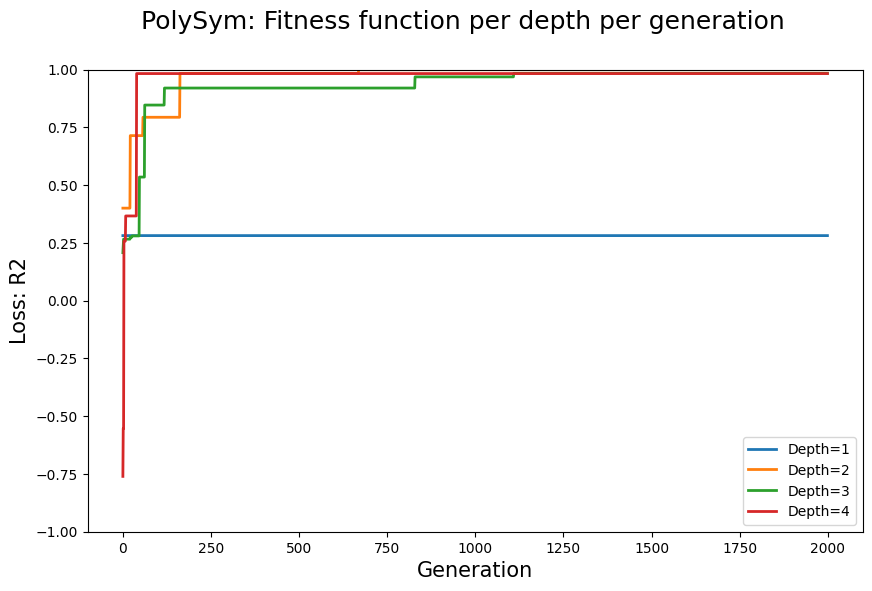

In [4]:
model.plot_differential_loss()

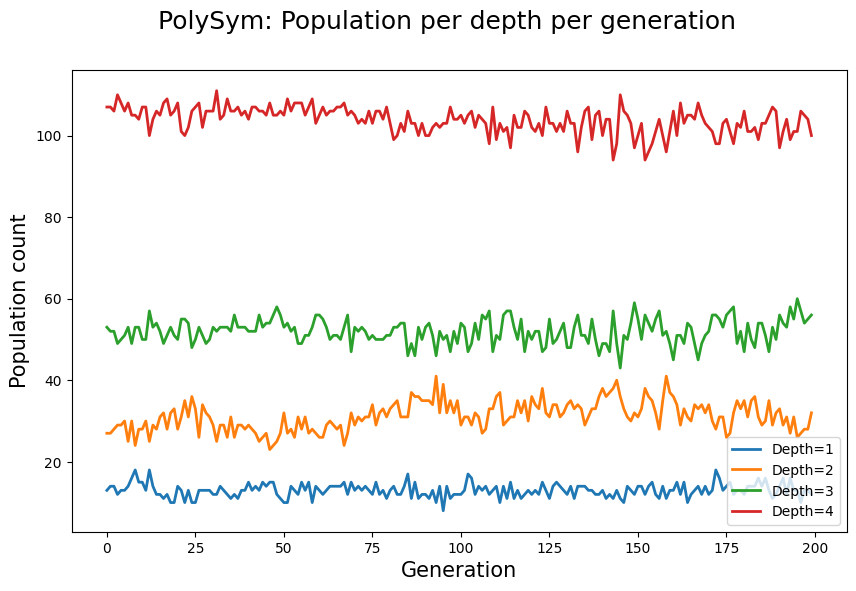

In [12]:
model.plot_depth_per_gen()

In [14]:
type(model.hof[0])

deap.creator.Individual

In [227]:
from polysym.eval_rank import is_valid_tree

depth = 5
operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])
model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y1d,
                        operators=operators,
                        min_complexity=5,
                        max_complexity=depth,
                        scale=False,
                        pop_size=300,
                        stopping_criterion=.99,
                        max_iter=20,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=42,
                        verbose=1,
                        workers=-1)

pop = model.toolbox.population(n=100)
heights_constraint = [i.height != depth for i in pop]
dim_mismatches = [model.toolbox.evaluate(i)[1] for i in pop]
are_valids = [is_valid_tree(ind, 1) for ind in pop]
any(heights_constraint), any(dim_mismatches), sum(dim_mismatches), sum(are_valids)

(False, False, 0, 100)

In [17]:
import sympy as sp

model.pset.primitives[object][0].__dir__()

['__module__',
 '__firstlineno__',
 '__doc__',
 '__slots__',
 '__init__',
 'format',
 '__eq__',
 '__static_attributes__',
 'args',
 'arity',
 'name',
 'ret',
 'seq',
 '__hash__',
 '__new__',
 '__repr__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [22]:
model.pset.primitives[object][0].seq

'unary_neg({0})'

In [24]:
model.pset.terminals[object]

 deap.gp.randc]

In [ ]:
# dfs generation:
# Root node always operator (reducer/unary?)
# Recursive call with required rank of variable (or free)
# Choose whether operator or variable
# If depth reached (or caller func did call a stop) add variable (terminal)
